### Check the author's notebook for a bunch of important information

## Load dependencies

In [1]:
# for data input and output:
import numpy as np
import os

# for deep learning:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new!
from keras.layers import Conv2DTranspose, UpSampling2D # new!
from keras.optimizers import RMSprop # new!

# for plotting:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load and preprocess data

In [2]:
# I downloaded the data from here: https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap, 
# however I did not save it under the suggested name or place.

In [3]:
input_images = 'full_numpy_bitmap_apple.npy'

In [4]:
data = np.load(input_images) # 28*28 (sound familiar?) grayscale bitmapin numpy .npy format; images are centered

In [5]:
data.shape
# There are 144,722 images, each 28*28 pixels

(144722, 784)

In [6]:
data[4242]
# By taking a look at the 4243rd image (0-indexing), we can see that the quickdraw images not only have the same dimensions 
# as the MNIST digits, but they are also represented as 8-bit integers, that is, integers ranging from 0 to 255.

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
data = data/255
data = np.reshape(data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]

# Let's examine this code line by line:

    # We divide by 255 to scale our pixels to be in the range of 0 to 1, just as we did for the MNIST digits.

    # The first hidden layer of our discriminator will consist of two-dimensional convolutional filters, so we convert the 
    # images from 1*784-pixel arrays to 28*28-pixel matrices. The NumPy reshape() method does this for us. Note that the 
    # fourth dimension is 1 because the images are monochromatic; it would be 3 if the images were full-color.

    # We store the image width (img_w) and image height (img_h) for use later.

In [32]:
data.shape

(144722, 28, 28, 1)

In [8]:
data[4242]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.14117647],
        [0.30980392],
        [0.        ],
        [0.        ],
        

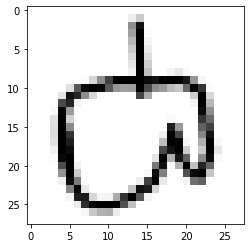

In [9]:
plt.imshow(data[4242,:,:,0], cmap='Greys')
# The actual image

## Create discriminator network

In [11]:
def build_discriminator(depth=64, p=0.4):
    
    # Define inputs:
    image = Input((img_w, img_h, 1))
    
    # Convolutional layers:
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer:
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition:
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [12]:
'''
For the first time in this book, rather than create a model architecture directly we instead define a function (
build_discriminator) that returns the constructed model object. Let's break down each piece of the model:

    The input images are 28*28 pixels in size. This is passed to the input layer by the variables img_w and img_h.

    There are four hidden layers, and all of them are convolutional.

    The number of convolutional filters per layer doubles layer-by-layer such that the first hidden layer has 64 
    convolutional filters (and therefore outputs an activation map with a depth of 64), whereas the fourth hidden layer has 
    512 convolutional filters (corresponding to an activation map with a depth of 512). More filters lead to more parameters
    and more model complexity, but also contribute to greater sharpness in the images the GANs produce. These values work 
    well enough for this example.

    The filter size is held constant at 5*5. We've largely used a filter size of 3*3 thus far in the book, although GAns can
    benefit from a slightly larger filter size, especially earlier in the network.

    The stride length for the first three convolutional layers is 2*2, which means that the activation map's height and 
    width are roughly halved by each of these layers. The stride length for the last convolutional layer is 1*1, so the 
    activation map it outputs has the same height and width as the activation map input into it (4*4).

    Dropout of 40 percent (p=0.4) is applied to every convolutional layer.

    We flatten the three-dimensional activation map from the final convolutional layer so that we can feed it into the dense
    output layer.

    As with the film sentiment models in Chapter 11 (Natural Language Processing), discriminating real images from fakes is 
    a binary classification task, so our (dense) outpout layer consists of a single sigmoid neuron.
'''

"\nFor the first time in this book, rather than create a model architecture directly we instead define a function (\nbuild_discriminator) that returns the constructed model object. Let's break down each piece of the model:\n\n    The input images are 28*28 pixels in size. This is passed to the input layer by the variables img_w and img_h.\n\n    There are four hidden layers, and all of them are convolutional.\n\n    The number of convolutional filters per layer doubles layer-by-layer such that the first hidden layer has 64 \n    convolutional filters (and therefore outputs an activation map with a depth of 64), whereas the fourth hidden layer has \n    512 convolutional filters (corresponding to an activation map with a depth of 512). More filters lead to more parameters\n    and more model complexity, but also contribute to greater sharpness in the images the GANs produce. These values work \n    well enough for this example.\n\n    The filter size is held constant at 5*5. We've large

In [13]:
# To build the discriminator, we call our build_discriminator function without any arguments:
discriminator = build_discriminator()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
discriminator.summary()
# 76% of the model's parameters come from the the final convolutional layer. For a great visualization, go to page 268 on 
# the book

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [15]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
'''
Let's examine the last cell line by line:

    As in chapter 11, we use the binary cross-entropy cost function because the discriminator is a binary classification 
    model.
    
    Introduced in chapter 9 (Improving Deep Networks), RMSprop (root mean square propagation)is an alternative "fancy 
    optimizer" to Adam. Ian Goodfellow and his colleagues published the first GAN paper in 2014. At the time, RMSprop was an
    optimizer already in vogue (the researchers Kingma and Ba published on Adam in 2014 as well, and it has become more 
    popular in the years since). You might need to tune the hyperparameters a bit, but you could probably substitute RMSprop
    with Adam to similar effect.
    
    The dacy rate (decay, p) for the RMSprop optimizer is a hyperparameter described in chapter 9.
    
    Finally, clipvalue is a hyperparameter that prevents (i.e., clips) the gradient of learning (the partial-derivative 
    relationship between cost and parameter values during stochastic gradient descent) from exceeding this value; clipvalue 
    thereby explicitly limits exploding gradients (see chapter 9). This particular value of 1.0 is common.
'''

'\nLet\'s examine the last cell line by line:\n\n    As in chapter 11, we use the binary cross-entropy cost function because the discriminator is a binary classification \n    model.\n    \n    Introduced in chapter 9 (Improving Deep Networks), RMSprop (root mean square propagation)is an alternative "fancy \n    optimizer" to Adam. Ian Goodfellow and his colleagues published the first GAN paper in 2014. At the time, RMSprop was an\n    optimizer already in vogue (the researchers Kingma and Ba published on Adam in 2014 as well, and it has become more \n    popular in the years since). You might need to tune the hyperparameters a bit, but you could probably substitute RMSprop\n    with Adam to similar effect.\n    \n    The dacy rate (decay, p) for the RMSprop optimizer is a hyperparameter described in chapter 9.\n    \n    Finally, clipvalue is a hyperparameter that prevents (i.e., clips) the gradient of learning (the partial-derivative \n    relationship between cost and parameter valu

## Create generator network

In [17]:
'''
Although the CNN architecture of the discriminator network should largely look familiar, the generator network contains a 
number of aspects that you haven't encountered previously in the book. 
We refer to the generator as a deCNN because it features de-convolutional layers (also known as convTranspose layers) that 
perform the opposite function of the typical convolutional layers you've encountered so far. Instead of detecting features 
and ouputting an activation map of where the features occur in the image, de-convolutional layers take in an activation map
and arrange the features spatially as outputs. An early step in the generative network reshapes the noise input (a one-
dimensional vector) into a two-dimensional array that can be used by the de-convolutional layers. Through several layers of 
de-convolution, the generator converts the random noise inputs into fake images that should resemble the ones in the 
dataset.
'''

"\nAlthough the CNN architecture of the discriminator network should largely look familiar, the generator network contains a \nnumber of aspects that you haven't encountered previously in the book. \nWe refer to the generator as a deCNN because it features de-convolutional layers (also known as convTranspose layers) that \nperform the opposite function of the typical convolutional layers you've encountered so far. Instead of detecting features \nand ouputting an activation map of where the features occur in the image, de-convolutional layers take in an activation map\nand arrange the features spatially as outputs. An early step in the generative network reshapes the noise input (a one-\ndimensional vector) into a two-dimensional array that can be used by the de-convolutional layers. Through several layers of \nde-convolution, the generator converts the random noise inputs into fake images that should resemble the ones in the \ndataset.\n"

In [35]:
z_dimensions = 32

def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    
    # Define inputs:
    noise = Input((latent_dim,))
    
    # First dense layer:
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers:
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    # Output layer:
    image = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    # Model definition:
    model = Model(inputs=noise, outputs=image)
    
    return model

In [19]:
'''
Let's go through the architecture in detail:

    We specify the number of dimensions in the input noise vector (z_dimensions) as 32. Configurating this hyperparameter 
    follows the same advice we gave for selecting the number of dimensions in word-vector space in Chapter 11: A higher-
    dimensional noise vector has the capacity to store more information and thus can improve the quality of the GAN's fake-
    image output;however, this comes at the cost of increased computational complexity. Generally, we recommend 
    experimenting with varying this hyperparameter by multiples of 2.
    
    As with our discriminator model architecture, we again opted to wrap our generator architecture within a function.
    
    The input is the random noise array with a length corresponding to latent_dim, which in this case is 32.
    
    The first hidden layer is a dense layer. This fully connected layer enables the latent-space input to be flexibly mapped
    to the spatial (de-convolutional) layers that follow. The 32 input dimensions are mapped to 3,136 (64*7*7)neurons in the
    dense layer, which outputs a one-dimensional array of activations. These activations are then reshaped into a 7*7*64 
    activation map.This dense layer is the only layer in the generator where dropout is applied.
    
    The network has three de-convolutional layers (specified by Conv2DTranspose). The first has 32 filters, and this number 
    is halved successively in the remaining two layers (As with convolutional layers, the number of filters in the layer 
    corresponds to the number of slices- the depth- of the activation map the layer outputs). While the number of filters 
    decreases, the size of the filters increases, thanks to the unsampling layers (UpSampling2D). Each time unsampling is 
    applied (with its default parameters, as we use it here), both the height and the width of the activation map double (
    This makes unsampling roughly the inverse of pooling). All three de-convolutional layers have the following:
    
        5*5 filters
        
        Stride of 1*1 (the default)
        
        Padding set to 'same' to maintain the dimensions of the activation maps after de-convolution
        
        ReLU activation functions
        
        Batch normalization applied (to promote regularization)
        
    The output layer is a single convolutional layer that collapses the 28*28*8 activation maps into a single 28*28*1 image.
    The sigmoid activation function in this last step ensures that the pixel values range from 0 to 1, just like the data 
    from real images that we feed into the discriminator separately.
'''

"\nLet's go through the architecture in detail:\n\n    We specify the number of dimensions in the input noise vector (z_dimensions) as 32. Configurating this hyperparameter \n    follows the same advice we gave for selecting the number of dimensions in word-vector space in Chapter 11: A higher-\n    dimensional noise vector has the capacity to store more information and thus can improve the quality of the GAN's fake-\n    image output;however, this comes at the cost of increased computational complexity. Generally, we recommend \n    experimenting with varying this hyperparameter by multiples of 2.\n    \n    As with our discriminator model architecture, we again opted to wrap our generator architecture within a function.\n    \n    The input is the random noise array with a length corresponding to latent_dim, which in this case is 32.\n    \n    The first hidden layer is a dense layer. This fully connected layer enables the latent-space input to be flexibly mapped\n    to the spatial 

In [36]:
# Exactly as we did with the discriminator network, we call the build_generator function without supplying any arguments to 
# build the generator:
generator = build_generator()

In [37]:
# Calling the model's summary method shows that the generator has only 177,000 trainable parameters- a mere 4 percent of the
# number of parameters in the discriminator
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization_8 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_8 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 64)        0         
__________

## Create adversarial network

In [22]:
'''
By excecuting the code so far in this notebook, we have accomplished the following:

    With respect to discriminator training, we've constructed our discriminator network and compiled it: It's ready to be 
    trained on real and fake images so that it can learn how to distinguish between these two classes.
    
    With respect to generator training, we've constructed our generator network, bui it needs to be compiled as part of the 
    larger adversarial network in order to be ready for training.
'''

"\nBy excecuting the code so far in this notebook, we have accomplished the following:\n\n    With respect to discriminator training, we've constructed our discriminator network and compiled it: It's ready to be \n    trained on real and fake images so that it can learn how to distinguish between these two classes.\n    \n    With respect to generator training, we've constructed our generator network, bui it needs to be compiled as part of the \n    larger adversarial network in order to be ready for training.\n"

In [38]:
# To combine our generator and discriminator networks to build an adversarial network:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

In [24]:
'''
Let's break this code down:

    We use Input() to define the model's input z, which will be an array of random noise of length 32.
    
    Passing z into generator returns a 28*28 image output that we call img.
    
    For the purposes of generator training, the parameters of our discriminator network must be frozen, se we set the 
    discriminator's trainable attribute to False.
    
    We pass the fake img into the frozen discriminator network, which outputs a prediction (pred) as to whether the image is
    real or fake.
    
    Finally, using the Keras functional API's Model class, we construct the adversarial model. By indicating that the 
    adversarial model's input is z and the output is pred, the functional API determines that the adversarial network 
    consists of the generator passing img into the frozen discriminator.
'''

"\nLet's break this code down:\n\n    We use Input() to define the model's input z, which will be an array of random noise of length 32.\n    \n    Passing z into generator returns a 28*28 image output that we call img.\n    \n    For the purposes of generator training, the parameters of our discriminator network must be frozen, se we set the \n    discriminator's trainable attribute to False.\n    \n    We pass the fake img into the frozen discriminator network, which outputs a prediction (pred) as to whether the image is\n    real or fake.\n    \n    Finally, using the Keras functional API's Model class, we construct the adversarial model. By indicating that the \n    adversarial model's input is z and the output is pred, the functional API determines that the adversarial network \n    consists of the generator passing img into the frozen discriminator.\n"

In [39]:
# To compile the adversarial network:
adversarial_model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                          metrics=['accuracy'])

In [26]:
'''
The arguments to the compile() method are the same as those we used for the discriminator network, except that the 
optimizer's learning rate and decay have been halved. There's a somewhat delicate balance to bestruck between the rate at 
which the discriminator and the generator learn in order for the GAN to produce compelling fake images. If you were to 
adjust the optimizer hyperparameters of the discriminator model when compiling it, then you might find that you'd also need 
to adjust them for the adversarial model in order to produce satisfactory image outputs.

A tricky aspect of the GAN training process that is worth restating is that the same discriminator network parameters (
weights) are used during discriminator training and during adversarial training. The discriminator is not frozen across the 
board; it is only when it's a component of the adversarial model. In this way, during discriminator training the weights are
updated during backpropagation and the model learns to distinguish between real and fake images. The adversarial model, in 
contrast, was compiled with a frozen discriminator. This discriminator is the exact same model with the same weights, but 
when the adversarial model learns it does not updats the discriminator weights; it only updates the weights of the 
generator.
'''

"\nThe arguments to the compile() method are the same as those we used for the discriminator network, except that the \noptimizer's learning rate and decay have been halved. There's a somewhat delicate balance to bestruck between the rate at \nwhich the discriminator and the generator learn in order for the GAN to produce compelling fake images. If you were to \nadjust the optimizer hyperparameters of the discriminator model when compiling it, then you might find that you'd also need \nto adjust them for the adversarial model in order to produce satisfactory image outputs.\n\nA tricky aspect of the GAN training process that is worth restating is that the same discriminator network parameters (\nweights) are used during discriminator training and during adversarial training. The discriminator is not frozen across the \nboard; it is only when it's a component of the adversarial model. In this way, during discriminator training the weights are\nupdated during backpropagation and the model

## Train

In [40]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # sample real images:
        real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch, 28, 28, 1))
        
        # generate fake images:
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs, fake_imgs))
        
        # assign y labels for discriminator:
        y = np.ones([2*batch, 1])
        y[batch:,:] = 0
        
        # train discriminator:
        d_metrics.append(discriminator.train_on_batch(x, y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y:
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y = np.ones([batch, 1])
        
        # train adversarial net:
        a_metrics.append(adversarial_model.train_on_batch(noise, y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress and fake images:
        if (i+1)%100 == 0:
            
            print(f'Epoch # {i}')
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%d: [A loss: %f, acc: %f]" % \
            (i, running_a_loss/i, running_a_acc/i)
            print(log_mesg)
            
            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)
            
            plt.figure(figsize=(7,7))
            
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    return a_metrics, d_metrics

In [28]:
'''
This is the largest single chonk of code in the book, so from top to bottom, let's dissect it to understand it better:

    The two empty lists (e.g., d_metrics) and the four variables set to 0 (e.g., running_d_loss) are for tracking loss and 
    accuracy metrics for the discriminator (d) and adversarial (a) networks as they train.
    
    We use the for loop to train for however many epochs we'd like. Note that while the term epoch is commonly used by GAN 
    developers for this loop, it would be more accurate to call it a batch: During each iteration of the for loop, we will 
    sample only 128 apple sketches from our dataset of hundreds of thousands of such sketches.
    
    Within each epoch, we alternate between discriminator training and generator training.
    
    To train the dicriminator, we:
    
        Sample a batch of 128 real images.
        
        Generate 128 fake images by creating noise vectors (z, sampled uniformly over the range [-1.0, 1.0]) and passing 
        them into the generator model's predict method. Note that by using the predict method, the generator is only 
        performing inference; it is generating images without updating any of its hyperparameters.
        
        Concatenate the real and fake images into a single variable x, which will serve as the input into our discriminator.
        
        Create an array, y, to label the images as real (y=1) or fake (y=0) so that they can be used to train the 
        discriminator.
        
        To train the discriminator, we pass our inputs x and labels y into the model's train_on_batch method.
        
        After each round of training, the training loss and accuracy metrics are appended to the d_metrics list.
        
    To train the generator we:
    
        Pass random noise vectors (stored in a variable called noise) as inputs as well as an array (y) of all-real labels 
        (i.e., y=1) into the train_on_batch method of the adversarial model.
        
        The generator component of the adversarial model converts the noise inputs into fake images, which are automatically
        passed as inputs into the discriminator component of the adversarial model.
        
        Because the discriminator's parameters are frozen during adversarial model training, the discriminator will simply 
        tell us whether it thinks the incoming images are real or fake. Even though rhw generator outputs fakes, they are 
        labeled as real (y=1) and the cross-entropy cost is used during backpropagation to update the weights of the 
        generator model. By minimizing this cost, the generator should learn to produce fake images that the discriminator
        mistakenly labels as real.
        
        After each round of training, the adversarial loss and accuracy metrics are appended to the a_metrics list.
        
    After every 100 epochs we:
    
        Print the epoch that we're in.
        
        Print a log message that includes the discriminator and adversarial model's running loss and accuracy metrics.
        
        Randomly sample 16 noise vectors and use the generator's predict method to generate fake images, which are stored in
        gen_imgs.
        
        Plot the 16 fake images in a 4*4 grid so that we can monitor the quality of the generator's images during training.
        
    At the conclusion of the train function, we return the lists of adversarial model and discriminator model metrics(
    a_metrics and d_metrics, respectively).
    
    Finally, we call the train function, saving the metrics into the a_metrics_complete and d_metrics_complete variables as 
    training progresses.
'''

"\nThis is the largest single chonk of code in the book, so from top to bottom, let's dissect it to understand it better:\n\n    The two empty lists (e.g., d_metrics) and the four variables set to 0 (e.g., running_d_loss) are for tracking loss and \n    accuracy metrics for the discriminator (d) and adversarial (a) networks as they train.\n    \n    We use the for loop to train for however many epochs we'd like. Note that while the term epoch is commonly used by GAN \n    developers for this loop, it would be more accurate to call it a batch: During each iteration of the for loop, we will \n    sample only 128 apple sketches from our dataset of hundreds of thousands of such sketches.\n    \n    Within each epoch, we alternate between discriminator training and generator training.\n    \n    To train the dicriminator, we:\n    \n        Sample a batch of 128 real images.\n        \n        Generate 128 fake images by creating noise vectors (z, sampled uniformly over the range [-1.0, 1.0

C:\Users\alex\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\alex\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch # 99
99: [A loss: 3.386119, acc: 0.154514]


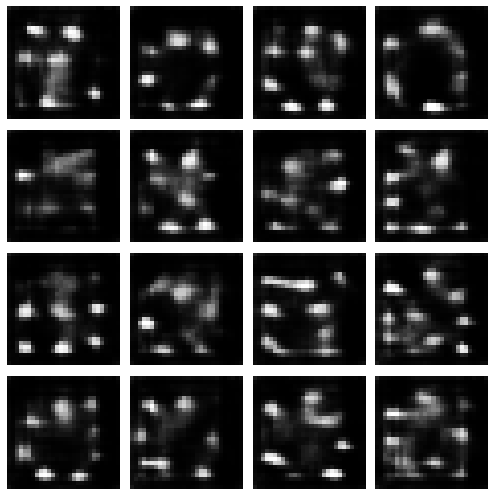

Epoch # 199
199: [A loss: 3.295628, acc: 0.110396]


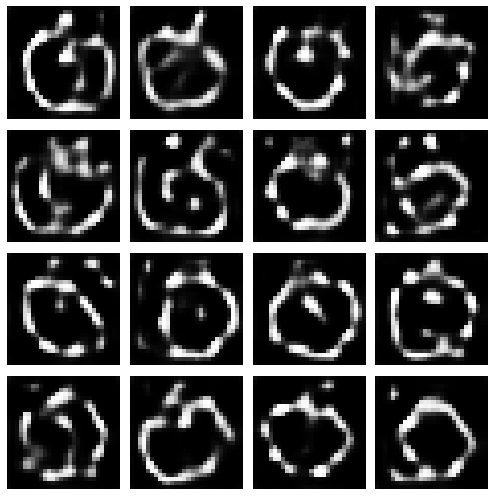

Epoch # 299
299: [A loss: 2.940666, acc: 0.115829]


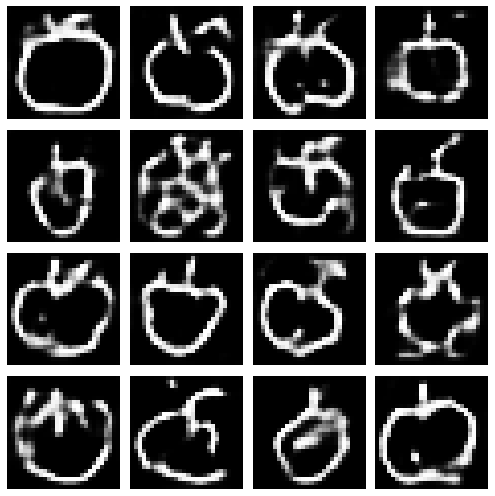

Epoch # 399
399: [A loss: 2.644836, acc: 0.120340]


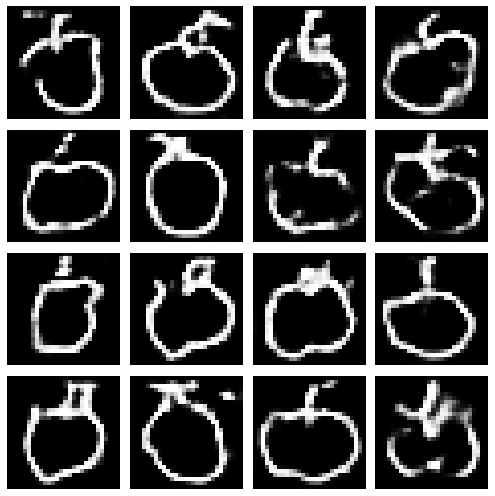

Epoch # 499
499: [A loss: 2.509224, acc: 0.121759]


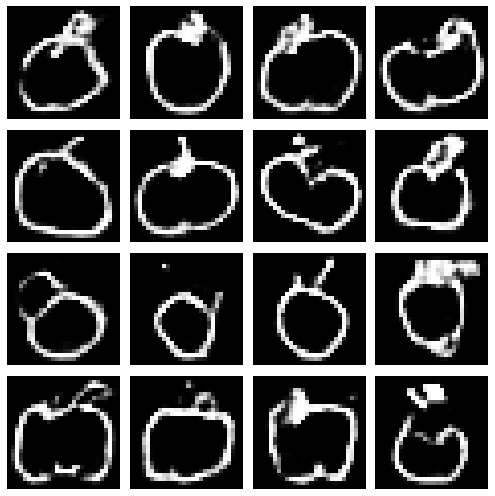

Epoch # 599
599: [A loss: 2.436619, acc: 0.124048]


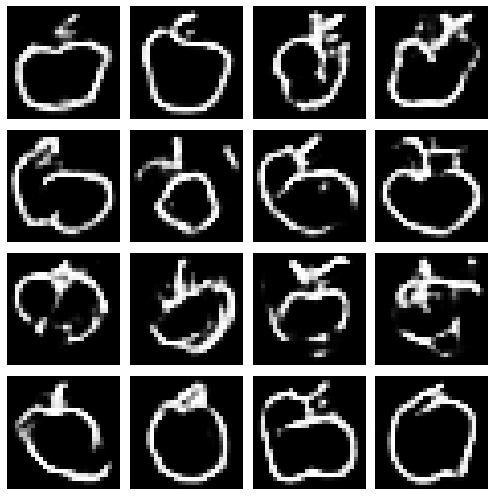

Epoch # 699
699: [A loss: 2.402956, acc: 0.125615]


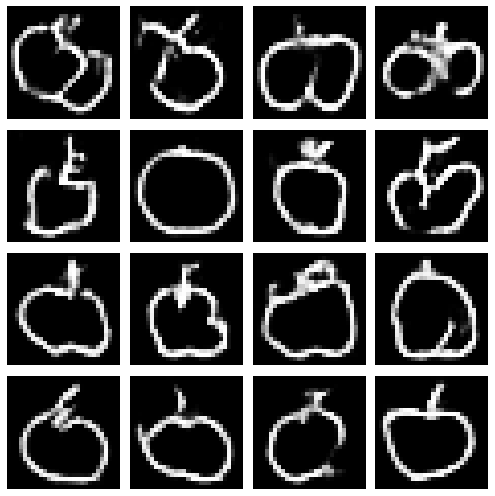

Epoch # 799
799: [A loss: 2.398774, acc: 0.124932]


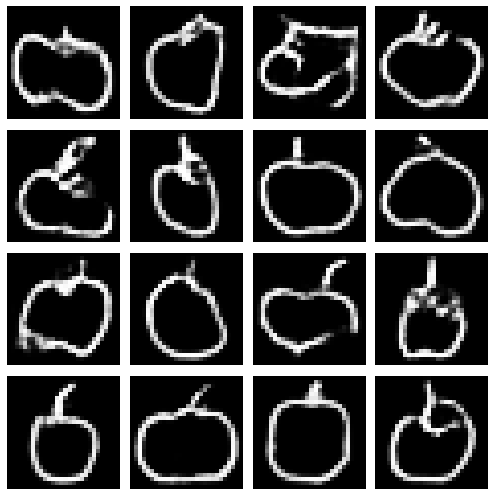

Epoch # 899
899: [A loss: 2.410461, acc: 0.123740]


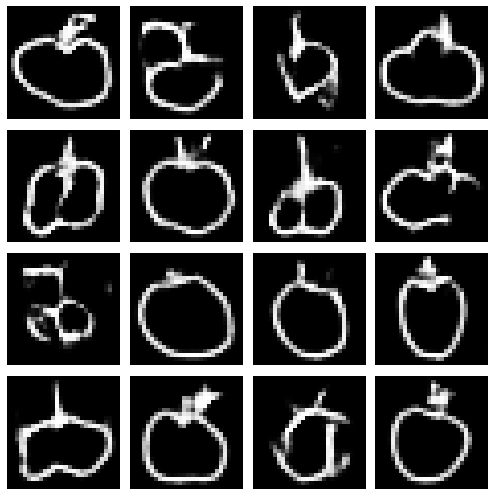

Epoch # 999
999: [A loss: 2.438502, acc: 0.122404]


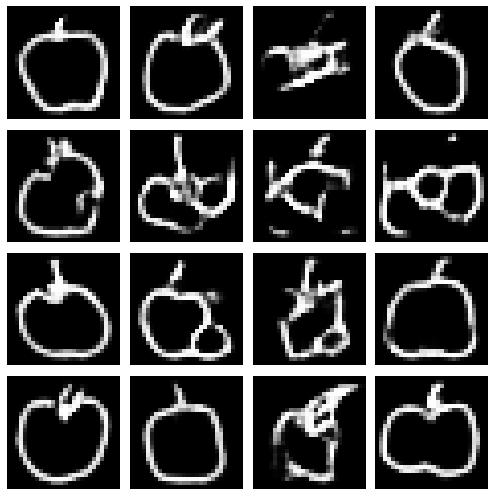

Epoch # 1099
1099: [A loss: 2.473136, acc: 0.119910]


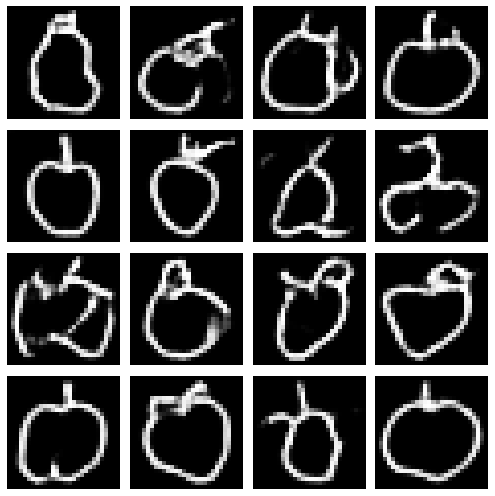

Epoch # 1199
1199: [A loss: 2.520092, acc: 0.117585]


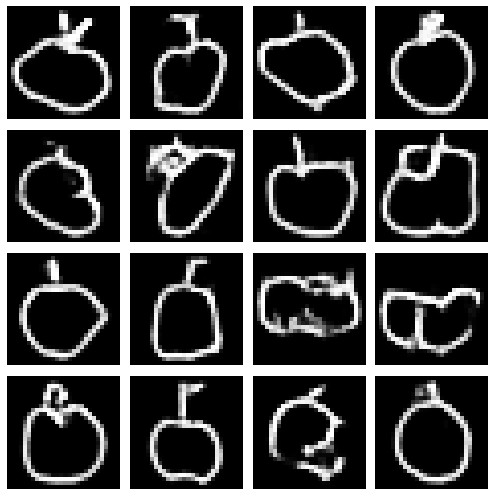

Epoch # 1299
1299: [A loss: 2.563245, acc: 0.115113]


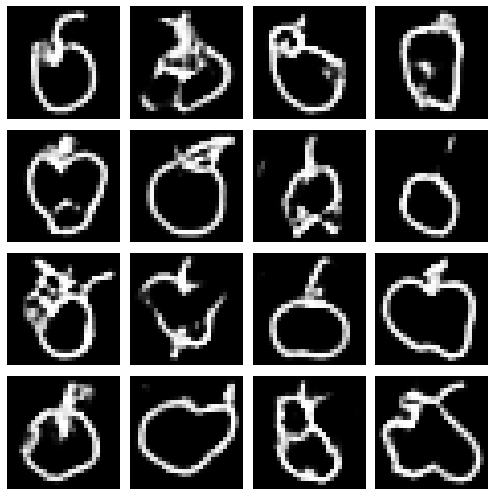

Epoch # 1399
1399: [A loss: 2.606566, acc: 0.113049]


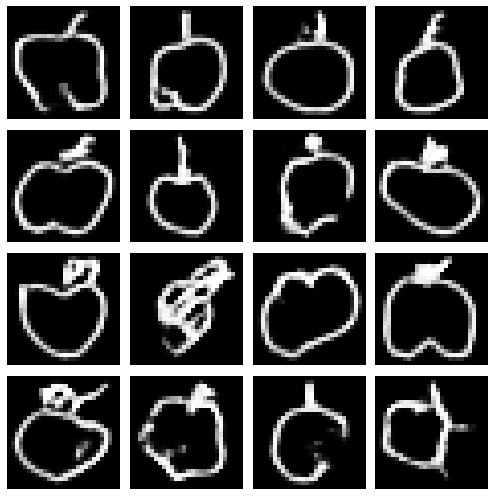

Epoch # 1499
1499: [A loss: 2.648800, acc: 0.111204]


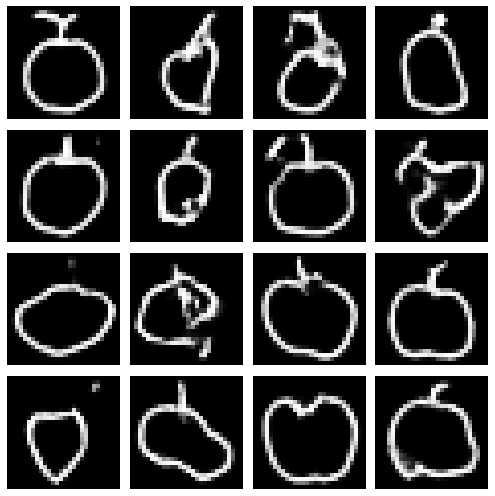

Epoch # 1599
1599: [A loss: 2.693450, acc: 0.109439]


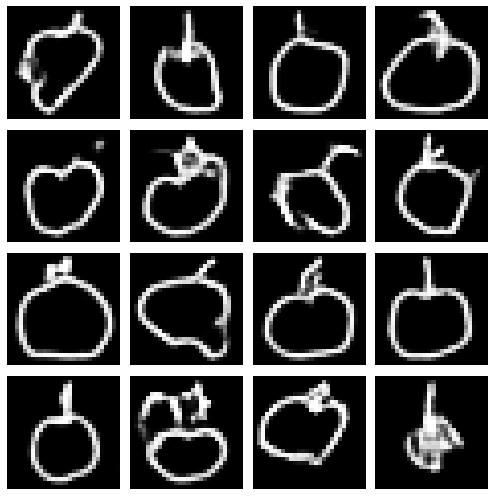

Epoch # 1699
1699: [A loss: 2.735863, acc: 0.107816]


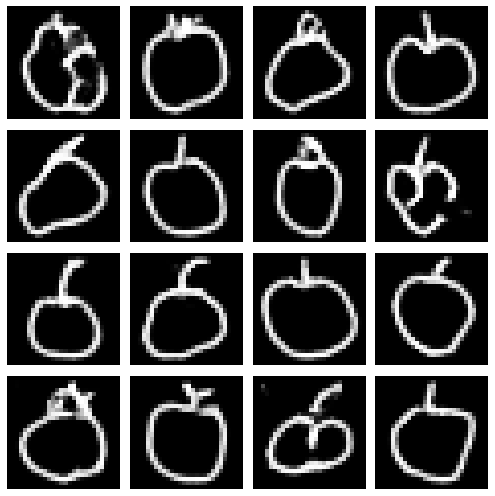

Epoch # 1799
1799: [A loss: 2.770496, acc: 0.106279]


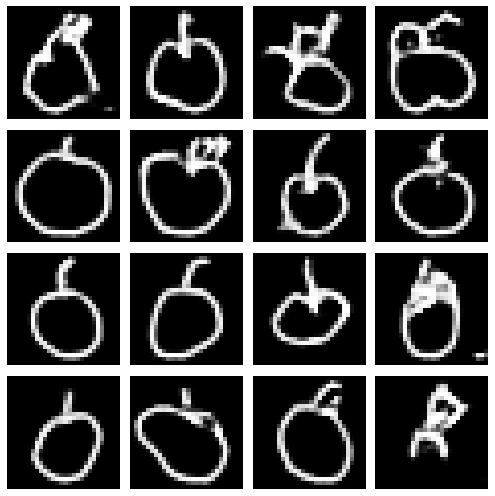

Epoch # 1899
1899: [A loss: 2.806224, acc: 0.104780]


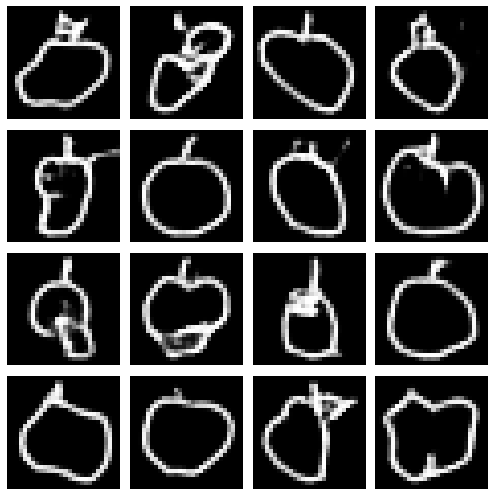

Epoch # 1999
1999: [A loss: 2.841490, acc: 0.103274]


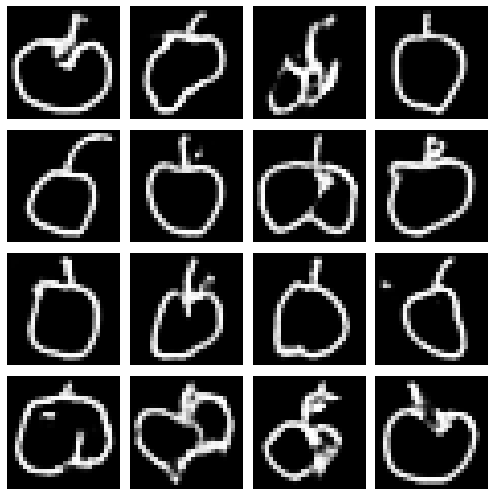


Total training time: 6661.561026334763 seconds


In [41]:
# The time addition was my own, not included by the author. I wanted to see how much time training took:
import time

# recording starting time since the epoch:
a = time.time()

a_metrics_complete, d_metrics_complete = train()

b = time.time()

print(f'\nTotal training time: {b - a} seconds')

Text(0, 0.5, 'Loss')

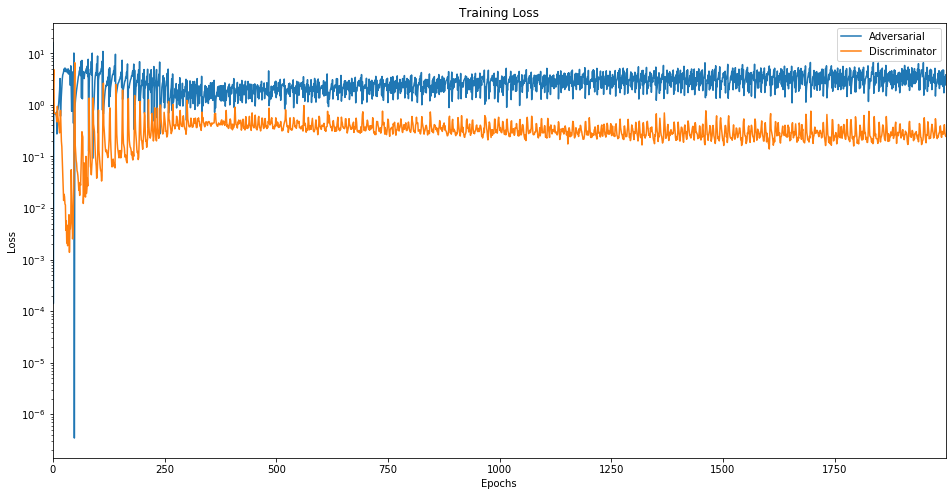

In [45]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete]}
).plot(title='Training Loss', logy=True, figsize=(16,8))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Text(0, 0.5, 'Accuracy')

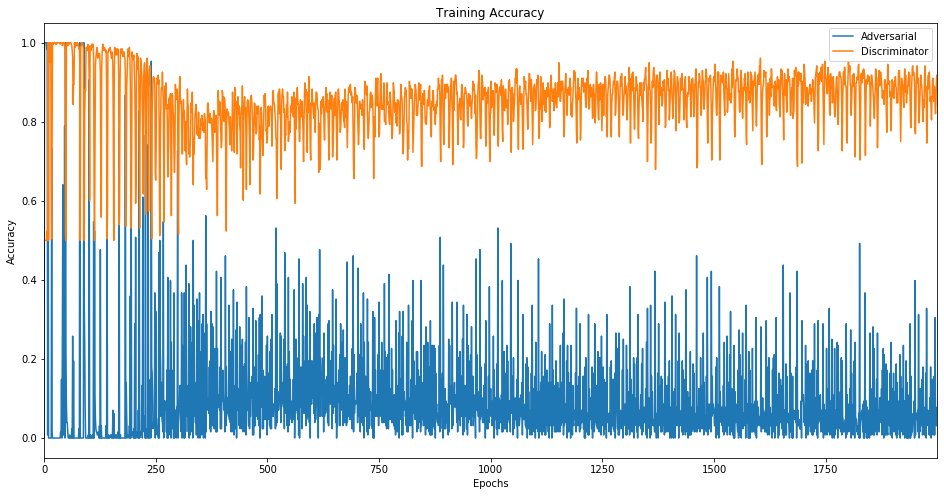

In [47]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete]
    }

).plot(title='Training Accuracy', figsize=(16,8))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

In [48]:
'''
The graphs show that the adversarial model's loss declined as the quality of the apple-sketch forgeries improved; that is 
what we'd expect because this rose over the first 300 epochs. From the ~300th epoch onward, the discriminator modestly 
improved at its binary classification task, corresponding to a gentle decrease in its training loss and an increase in its 
training accuracy.
'''

"\nThe graphs show that the adversarial model's loss declined as the quality of the apple-sketch forgeries improved; that is \nwhat we'd expect because this rose over the first 300 epochs. From the ~300th epoch onward, the discriminator modestly \nimproved at its binary classification task, corresponding to a gentle decrease in its training loss and an increase in its \ntraining accuracy.\n"